# Информационная безопасность - анализ сетевого трафика

Компания онлайн-сервис с высоким уровнем входящего трафика имеет специализированный отдел безопасности, который занимается фильтрацией и анализом трафика. Сотрудники этого отдела обратились за помощью в автоматизации выявления аномального и злонамеренного трафика.

### Цель: 
Разработать модель, которая будет классифицировать трафик на нормальный и злонамеренный, включая следующие типы атак: DDoS, SQL-инъекции, брутфорс, вредоносные программы и т.д. Полученая модель достигнет наилучшего значения по различным метрикам классификации: precision, recall, f1_score, accuracy.

### Задачи:

загрузить и ознакомится с данными,

провести предварительную обработку,

сделать полноценный разведочный анализ,

разработать новые синтетические признаки,

проверить на мультиколлинеарность,

сделать отбор финального набора обучающих признаков,

выбрать и обучить модели,

провести итоговую оценку качества предсказания лучшей модели,

сделать анализ важности признаков модели.

### Входные данные.
Файл в формате .csv с различными параметрами входящего трафика (~540000 строк)


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import os
from datetime import datetime, timedelta
from numpy.random import RandomState
from time import time

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import lightgbm as lgb
from catboost import Pool, CatBoostClassifier

In [13]:
state = RandomState(12345)

In [5]:
df = pd.read_csv('C:/Users/Family/Downloads/network_traffic_data.csv')

In [10]:
print(f"Number of NaNs is {(df.isna().sum() > 0).sum()}")

Number of NaNs is 1


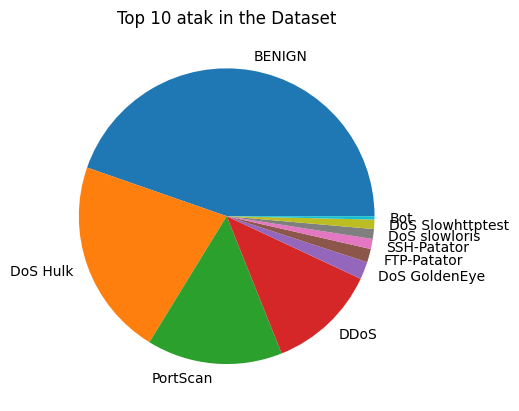

In [12]:
protocol_name = df['Label'].value_counts(ascending=False)[:10]
names, count = protocol_name.index.values, protocol_name.values
plt.pie(count, labels=names);
plt.title("Top 10 atak in the Dataset");

In [24]:
def info_df(df_name):
    st = df_name.shape[0]
    col = df_name.shape[1]
    zerro = df_name.isna().sum()
    los = df_name.isna().sum()
    print(f'Размер таблиы: {col} столбцов и {st} строк')
    print(f'Общее количество пропусков - {zerro.sum()}')
    print(los[los!=0])
    print()
    print(df_name.describe().round(2))
    print ()
    print(df_name.head())
    print()
    print(df_name.info())
    print()
    print(f'Количество явных дубликатов: {df_name.duplicated().sum()}')

In [25]:
info_df(df)

Размер таблиы: 79 столбцов и 539616 строк
Общее количество пропусков - 488
Flow Bytes/s    488
dtype: int64



C:\Users\Family\anaconda3\envs\ds_practicum_env\lib\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\Family\anaconda3\envs\ds_practicum_env\lib\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


        Destination Port   Flow Duration   Total Fwd Packets  \
count          539616.00    5.396160e+05           539616.00   
mean             5563.06    2.106693e+07                6.12   
std             14921.26    3.812172e+07              345.11   
min                 0.00   -1.200000e+01                1.00   
25%                80.00    7.300000e+01                1.00   
50%                80.00    4.973900e+04                2.00   
75%               443.00    1.064030e+07                6.00   
max             65533.00    1.200000e+08           200755.00   

        Total Backward Packets  Total Length of Fwd Packets  \
count                539616.00                    539616.00   
mean                      5.99                       408.24   
std                     463.49                      7478.35   
min                       0.00                         0.00   
25%                       1.00                         2.00   
50%                       2.00               

Количество явных дубликатов: 64601


In [26]:
df.nunique().sort_values().head(20)

Fwd Avg Bytes/Bulk        1
 Bwd PSH Flags            1
 Fwd Avg Packets/Bulk     1
 Fwd Avg Bulk Rate        1
 Bwd Avg Bytes/Bulk       1
 Bwd Avg Packets/Bulk     1
Bwd Avg Bulk Rate         1
 Bwd URG Flags            1
 CWE Flag Count           2
Fwd PSH Flags             2
FIN Flag Count            2
 SYN Flag Count           2
 RST Flag Count           2
 PSH Flag Count           2
 ACK Flag Count           2
 URG Flag Count           2
 Fwd URG Flags            2
 ECE Flag Count           2
 Down/Up Ratio           12
Label                    15
dtype: int64

In [30]:
# 8 признаков с одним значением
# 10 признаков с двумя значениями 
# Создадим списки признаков с недостаточным числом значений
train_1_class = ['Fwd Avg Bytes/Bulk', ' Bwd PSH Flags', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate', ' Bwd URG Flags']
train_2_class = [' CWE Flag Count', 'Fwd PSH Flags', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count', ' URG Flag Count', ' Fwd URG Flags', ' ECE Flag Count']


In [31]:
class_0 = []
class_1 = []
for i in train_2_class:
    class_0.append(df[i].value_counts()[0])
    class_1.append(df[i].value_counts()[1])

df_train_2_class = pd.DataFrame({
    'params':train_2_class, 
    'class_0':class_0,
    'class_1':class_1
})

df_train_2_class

,params,class_0,class_1
0,CWE Flag Count,539586,30
1,Fwd PSH Flags,519787,19829
2,FIN Flag Count,505877,33739
3,SYN Flag Count,519787,19829
4,RST Flag Count,539551,65
5,PSH Flag Count,335768,203848
6,ACK Flag Count,342179,197437
7,URG Flag Count,506933,32683
8,Fwd URG Flags,539586,30
9,ECE Flag Count,539551,65


In [34]:
# Определим классы, к которым принадлежат признаки со смещенным балансом
print(' CWE Flag Count', df.loc[df[' CWE Flag Count']==1, 'Label'].value_counts())
print(' RST Flag Count', df.loc[df[' RST Flag Count']==1, 'Label'].value_counts())
print(' Fwd URG Flags', df.loc[df[' Fwd URG Flags']==1, 'Label'].value_counts())
print(' ECE Flag Count', df.loc[df[' ECE Flag Count']==1, 'Label'].value_counts())

 CWE Flag Count Label
BENIGN    30
Name: count, dtype: int64
 RST Flag Count Label
BENIGN    65
Name: count, dtype: int64
 Fwd URG Flags Label
BENIGN    30
Name: count, dtype: int64
 ECE Flag Count Label
BENIGN    65
Name: count, dtype: int64


In [35]:
# Создадим списк признаков с двумя значениями и смещенным балансом
train_2_class_short = [' CWE Flag Count', ' RST Flag Count', ' Fwd URG Flags', ' ECE Flag Count']

In [36]:
# Изуачение баланса классов 
df['Label'].value_counts()

Label
BENIGN                        240000
DoS Hulk                      115974
PortScan                       79660
DDoS                           64366
DoS GoldenEye                  10293
FTP-Patator                     7938
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1966
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Infiltration                      36
Web Attack � Sql Injection        21
Heartbleed                        11
Name: count, dtype: int64

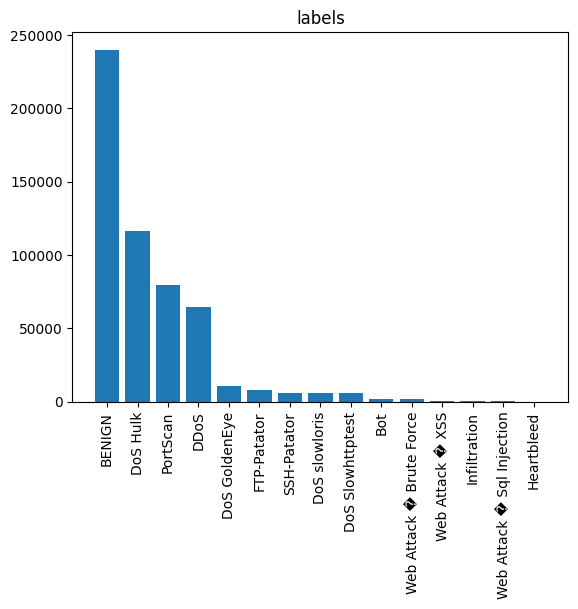

In [37]:
labels = df['Label'].value_counts().index
counts = df['Label'].value_counts().values


plt.bar(labels, counts)
plt.tick_params(axis='x', labelrotation = 90)
plt.title('labels')
plt.show()

#### Проверка данных на мультиколлинеарность

In [38]:
df_corr = df.drop('Label', axis=1)
df_corr = df_corr.corr(numeric_only=True)

In [39]:
df_corr.head(3)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
Destination Port,1.000000,-0.179121,-0.004491,-0.003684,0.011943,-0.002828,0.085761,-0.008278,0.125459,0.108413,...,-0.003234,0.000855,-0.044212,-0.032972,-0.049732,-0.035651,-0.158890,-0.025703,-0.159201,-0.155937
Flow Duration,-0.179121,1.000000,0.018046,0.015152,0.052678,0.012175,0.253809,-0.090833,0.127411,0.240087,...,0.012132,-0.001428,0.191943,0.186125,0.242334,0.137895,0.883483,0.272722,0.902281,0.849129
Total Fwd Packets,-0.004491,0.018046,1.000000,0.999204,0.228154,0.998667,0.012555,-0.002313,0.002589,0.004294,...,0.809370,-0.000011,0.014050,0.013113,0.017742,0.010058,0.003286,0.001856,0.003522,0.002994


In [40]:
# Создадим словарь со значениями параметров, имеющих высокую взамимную корреляцию
corr_max = 0.8
corr_min = -0.8
corr_diht = {}

for i in range(len(df_corr.columns)):
    a = df_corr.loc[(df_corr[df_corr.columns[i]]!=1)&(df_corr[df_corr.columns[i]]!=-1)&
            ((df_corr[df_corr.columns[i]]>corr_max)|(df_corr[df_corr.columns[i]]<corr_min)), 
            df_corr.columns[i]]
    if len(a) != 0:
        corr_diht[df_corr.columns[i]] = list(a.index)

In [41]:
# Визуализируем мультиколлинеарность
df_multicorr = pd.DataFrame.from_dict(corr_diht, orient='index')
df_multicorr

,0,1,2,3,4,5,6,7
Flow Duration,Flow IAT Std,Flow IAT Max,Fwd IAT Total,Fwd IAT Std,Fwd IAT Max,Idle Mean,Idle Max,Idle Min
Total Fwd Packets,Total Backward Packets,Total Length of Bwd Packets,Subflow Bwd Packets,Subflow Bwd Bytes,act_data_pkt_fwd,None,None,None
Total Backward Packets,Total Fwd Packets,Total Length of Bwd Packets,Subflow Fwd Packets,Subflow Bwd Bytes,act_data_pkt_fwd,None,None,None
Total Length of Bwd Packets,Total Fwd Packets,Total Backward Packets,Subflow Fwd Packets,Subflow Bwd Packets,Subflow Bwd Bytes,act_data_pkt_fwd,None,None
Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Std,Avg Fwd Segment Size,None,None,None,None,None
Fwd Packet Length Mean,Fwd Packet Length Max,Fwd Packet Length Std,None,None,None,None,None,None
Fwd Packet Length Std,Fwd Packet Length Max,Fwd Packet Length Mean,Avg Fwd Segment Size,None,None,None,None,None
Bwd Packet Length Max,Bwd Packet Length Mean,Bwd Packet Length Std,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,Average Packet Size,Avg Bwd Segment Size
Bwd Packet Length Mean,Bwd Packet Length Max,Bwd Packet Length Std,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,Average Packet Size,None
Bwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Mean,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,Average Packet Size,Avg Bwd Segment Size


In [42]:
# Составим список столбцов, вызывающих мультиколлинеарность
# Список ключей
corr_list_key = list(corr_diht)

# Список столбцов, вызывающих мультиколлинеарность
multicorr_list = []
for i in corr_list_key:
    if i not in multicorr_list:
        multicorr_list += corr_diht[i]

#### Проверка данных на бесконечность

In [43]:
inf_plus = []
inf_minus = []

for i in df.columns:
    inf_plus.append(df.loc[df[i]==float('inf'), i].count())
    inf_minus.append(df.loc[df[i]==float('-inf'), i].count())
    
df_inf_class = pd.DataFrame({
    'params':df.columns, 
    'inf_plus':inf_plus,
    'inf_minus':inf_minus
})

df_inf_class.head(3)

,params,inf_plus,inf_minus
0,Destination Port,0,0
1,Flow Duration,0,0
2,Total Fwd Packets,0,0


In [44]:
df_inf_class.loc[df_inf_class['inf_plus']!=0]

,params,inf_plus,inf_minus
14,Flow Bytes/s,246,0
15,Flow Packets/s,734,0


In [45]:
df_inf_class.loc[df_inf_class['inf_minus']!=0]

,params,inf_plus,inf_minus


### Вывод:

Датасет содержит 79 столбцов и 539 616 строк. Общее число пропусков 488.

Признаки есть как числовые, так и категориальные. Ряд признаков имеют одно или два значения. 8 признаков с одним значением лишены смысла для целей обучения модели. Кроме того, есть 10 признаков с двумя значениями. У четырех из них классы не сбалансированы и также не имеют смысла для целей обучения модели.

Целевой признак не сбалансирован. Есть четыре вида вредоносного трафика, детектирование которого будет осложнятся их редкостью.

Проверка на мультиколлинеарность выявила 41 признак, имеющих взаимную корреляцию.

Два признака имеют значение бесконечность (inf). Наиболее оптимальным решением будет заменить их на максимальное значение.

## Подготовка данных

In [46]:
# Удалим явные дубликаты
df = df.drop_duplicates().reset_index(drop=True)
print('Количество явных дублей - ', df.duplicated().sum())

Количество явных дублей -  0


In [47]:
df.shape

(475015, 79)

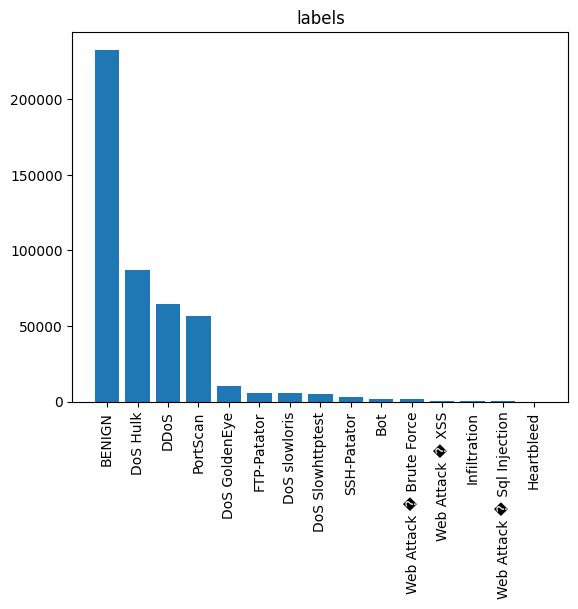

In [48]:
# Проверим наличие всех классов
labels = df['Label'].value_counts().index
counts = df['Label'].value_counts().values

plt.bar(labels, counts)
plt.tick_params(axis='x', labelrotation = 90)
plt.title('labels')
plt.show()

In [49]:
# Сформируем список столбцов, для удаления
drop_list = multicorr_list + train_1_class + train_2_class_short
drop_list = list(set(drop_list))

# Удалим столбцы
df.drop(drop_list, axis=1, inplace=True)

In [50]:
# Преобразуем нечисловые метки таргета в числовые 
le = LabelEncoder()
le.fit(list(df['Label'].unique()))

df['label_le'] = le.transform(df['Label'])

In [51]:
df.shape

(475015, 36)

In [52]:
# Разделим датасет на признаки и целевые результаты
features = df.drop(['Label', 'label_le'], axis=1)
target = df['label_le']

In [53]:
# Разделим на обучающую и тестовую выборки
# Разделим данные на обучающую и тестовую выборки

features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size=.2,                                                                            
                                                                            random_state=state)
print(f'Обучающая выборка признаков - {features_train.shape}')
print(f'Обучающая выборка целевого признака - {target_train.shape}')
print(f'Тестовая выборка признаков - {features_test.shape}')
print(f'Тестовая выборка целевого признака - {target_test.shape}')

Обучающая выборка признаков - (380012, 34)
Обучающая выборка целевого признака - (380012,)
Тестовая выборка признаков - (95003, 34)
Тестовая выборка целевого признака - (95003,)


In [54]:
# Баланс классов в обучающей выборке
target_train.value_counts()

label_le
0     186098
4      69764
2      51515
10     45083
3       8318
7       4700
6       4362
5       4216
11      2625
1       1583
12      1169
14       529
9         30
13        12
8          8
Name: count, dtype: int64

In [55]:
# Баланс классов в тестовой выборке
target_test.value_counts()

label_le
0     46711
4     17487
2     12849
10    11314
3      1968
7      1233
6      1023
5      1012
11      594
1       370
12      301
14      123
13        9
9         6
8         3
Name: count, dtype: int64

In [56]:
# Заполним пропуски медианным значениеи в обучающей и тестовой выборке

print('Пропусков в обучающей выборке')
print(features_train.isna().sum())
print()
print('Пропусков в тестовой выборке')
print(features_test.isna().sum())

Пропусков в обучающей выборке
 Destination Port               0
 Flow Duration                  0
 Total Fwd Packets              0
Total Length of Fwd Packets     0
 Fwd Packet Length Max          0
 Fwd Packet Length Min          0
Bwd Packet Length Max           0
 Bwd Packet Length Min          0
Flow Bytes/s                   34
 Flow Packets/s                 0
 Flow IAT Mean                  0
 Flow IAT Min                   0
 Fwd IAT Min                    0
Bwd IAT Total                   0
 Bwd IAT Mean                   0
 Bwd IAT Std                    0
Fwd PSH Flags                   0
 Fwd Header Length              0
 Bwd Packets/s                  0
 Min Packet Length              0
FIN Flag Count                  0
 SYN Flag Count                 0
 PSH Flag Count                 0
 ACK Flag Count                 0
 URG Flag Count                 0
 Down/Up Ratio                  0
 Fwd Header Length.1            0
Subflow Fwd Packets             0
 Subflow Fwd Bytes

In [58]:
features_train['Flow Bytes/s'] = features_train['Flow Bytes/s'].fillna(features_train['Flow Bytes/s'].median())
features_test['Flow Bytes/s'] = features_test['Flow Bytes/s'].fillna(features_test['Flow Bytes/s'].median())

In [59]:
print('Пропусков в обучающей выборке ', features_train.isna().sum().sum())
print('Пропусков в тестовой выборке ', features_test.isna().sum().sum())

Пропусков в обучающей выборке  0
Пропусков в тестовой выборке  0


In [60]:
# Определим размер данных с бесконечностью
print('features_train')
for i in ['Flow Bytes/s', ' Flow Packets/s']:
    print('inf ', i, features_train.loc[features_train[i]==float('inf'), i].count())
    print('-inf ', i, features_train.loc[features_train[i]==float('-inf'), i].count())

print('features_test')
for i in ['Flow Bytes/s', ' Flow Packets/s']:
    print('inf ', i, features_test.loc[features_test[i]==float('inf'), i].count())
    print('-inf ', i, features_test.loc[features_test[i]==float('-inf'), i].count())

features_train
inf  Flow Bytes/s 165
-inf  Flow Bytes/s 0
inf   Flow Packets/s 199
-inf   Flow Packets/s 0
features_test
inf  Flow Bytes/s 57
-inf  Flow Bytes/s 0
inf   Flow Packets/s 63
-inf   Flow Packets/s 0


In [61]:
for i in ['Flow Bytes/s', ' Flow Packets/s']:
    a = list(features_train[i])
    M = max(a)
    mm = max(n for n in a if n!=M)
    features_train[i] = features_train[i].replace(float('inf'), mm)

for i in ['Flow Bytes/s', ' Flow Packets/s']:
    a = list(features_test[i])
    M = max(a)
    mm = max(n for n in a if n!=M)
    features_test[i] = features_test[i].replace(float('inf'), mm)

In [62]:
# Определим размер данных с бесконечностью
print('features_train')
for i in ['Flow Bytes/s', ' Flow Packets/s']:
    print('inf ', i, features_train.loc[features_train[i]==float('inf'), i].count())
    print('-inf ', i, features_train.loc[features_train[i]==float('-inf'), i].count())

print('features_test')
for i in ['Flow Bytes/s', ' Flow Packets/s']:
    print('inf ', i, features_test.loc[features_test[i]==float('inf'), i].count())
    print('-inf ', i, features_test.loc[features_test[i]==float('-inf'), i].count())

features_train
inf  Flow Bytes/s 0
-inf  Flow Bytes/s 0
inf   Flow Packets/s 0
-inf   Flow Packets/s 0
features_test
inf  Flow Bytes/s 0
-inf  Flow Bytes/s 0
inf   Flow Packets/s 0
-inf   Flow Packets/s 0


In [63]:
# Проведем стандартизацию данных

scaler = StandardScaler()
scaler.fit(features_train)
features_train_skaled = scaler.transform(features_train)
features_test_skaled = scaler.transform(features_test)

print(f'Обучающая стандартизированная выборка признаков - {features_train_skaled.shape}')
print(f'Тестовая стандартизированная выборка признаков - {features_test_skaled.shape}')

Обучающая стандартизированная выборка признаков - (380012, 34)
Тестовая стандартизированная выборка признаков - (95003, 34)


### Вывод:

Сформирован сбалансированный набор показателей для эффективного детектирования вредоносного трафика.

Удалены явные дубликаты, заполнены пропуски данных и заменены значения бесконечности. Снижение уровня мультиколлинеарности достигнуто удалением 41 параметра. Также удалены параметры, имеющие одно значение или два несбалансированных значения. Все признаки стандартизированы, а целевой признак преобразован в числовой.

## Обучение моделей

In [64]:
target_names = list(df['Label'].unique())

1. Обучение методом Регрессии

In [65]:
%%time

model_regr = LogisticRegression()
model_regr.fit(features_train_skaled, target_train)

answer_regr = model_regr.predict(features_test_skaled)
f1_model_regr = f1_score(target_test, answer_regr, average='micro')

print(f'f1_score на регрессии - {f1_model_regr:.4f}')
print()
print(classification_report(target_test, answer_regr, target_names=target_names, zero_division = 0))

C:\Users\Family\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


f1_score на регрессии - 0.9524

                            precision    recall  f1-score   support

                    BENIGN       0.96      0.95      0.95     46711
                  PortScan       0.50      0.00      0.01       370
                  DoS Hulk       0.98      1.00      0.99     12849
                      DDoS       0.93      0.88      0.91      1968
                       Bot       0.95      0.99      0.97     17487
              Infiltration       0.90      0.84      0.87      1012
  Web Attack � Brute Force       0.85      0.88      0.87      1023
          Web Attack � XSS       0.88      0.99      0.93      1233
Web Attack � Sql Injection       1.00      0.67      0.80         3
               FTP-Patator       0.75      0.50      0.60         6
               SSH-Patator       0.93      0.99      0.96     11314
             DoS slowloris       0.00      0.00      0.00       594
          DoS Slowhttptest       0.59      0.04      0.08       301
             Do

2. Обучение методом Решающего дерева

In [66]:
%%time

# Подберем лучшие параметры Решающего дерева методом GridSearchCV
clf = DecisionTreeClassifier(random_state=state)
parametrs = {'max_depth': range(10, 31, 10)}

model_tree_cv = GridSearchCV(clf, parametrs, cv=5)
model_tree_cv.fit(features_train_skaled, target_train)
best_depth_tree = model_tree_cv.best_params_.get('max_depth')

print(f'Лучший параметр глубины - {best_depth_tree}')

# Обучим и проверим модель с подобранными параметрами
model_tree = DecisionTreeClassifier(max_depth=best_depth_tree, random_state=state)
model_tree.fit(features_train_skaled, target_train)
answer_tree = model_tree.predict(features_test_skaled)
f1_model_tree = f1_score(target_test, answer_tree, average='micro')

print(f'Решающее дерево с глубиной {best_depth_tree} достигает значение метрики F1 {f1_model_tree:.4f}')
print()
print(classification_report(target_test, answer_tree, target_names=target_names, zero_division = 0))

Лучший параметр глубины - 20
Решающее дерево с глубиной 20 достигает значение метрики F1 0.9968

                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     46711
                  PortScan       0.96      0.94      0.95       370
                  DoS Hulk       1.00      1.00      1.00     12849
                      DDoS       1.00      1.00      1.00      1968
                       Bot       1.00      1.00      1.00     17487
              Infiltration       0.99      1.00      0.99      1012
  Web Attack � Brute Force       1.00      0.99      0.99      1023
          Web Attack � XSS       1.00      1.00      1.00      1233
Web Attack � Sql Injection       1.00      0.67      0.80         3
               FTP-Patator       0.83      0.83      0.83         6
               SSH-Patator       1.00      1.00      1.00     11314
             DoS slowloris       1.00      1.00      1.00       594
          DoS Slow

3. Обучение методом Случайного леса

In [68]:
%%time

# Подберем лучшие параметры Случайного леса методом GridSearchCV
clf = RandomForestClassifier(max_depth=best_depth_tree, random_state=state)
parametrs = {'n_estimators': range(30, 91, 30)}

model_forest_cv = GridSearchCV(clf, parametrs, cv=5)
model_forest_cv.fit(features_train_skaled, target_train)
best_est_forest = model_forest_cv.best_params_.get('n_estimators')

print(f'Лучший параметр числа деревьев - {best_est_forest}')

# Обучим и проверим модель с подобранными параметрами
model_forest = RandomForestClassifier(max_depth=best_depth_tree, n_estimators=best_est_forest, random_state=state)
model_forest.fit(features_train_skaled, target_train)
answer_forest = model_forest.predict(features_test_skaled)
f1_model_forest = f1_score(target_test, answer_forest, average='micro')

print(f'случайный лес с числом деревьев {best_est_forest} достигает значение метрики F1 {f1_model_forest:.4f}')
print()
print(classification_report(target_test, answer_forest, target_names=target_names, zero_division = 0))

Лучший параметр числа деревьев - 90
случайный лес с числом деревьев 90 достигает значение метрики F1 0.9976

                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     46711
                  PortScan       0.96      0.95      0.95       370
                  DoS Hulk       1.00      1.00      1.00     12849
                      DDoS       1.00      1.00      1.00      1968
                       Bot       1.00      1.00      1.00     17487
              Infiltration       1.00      1.00      1.00      1012
  Web Attack � Brute Force       1.00      1.00      1.00      1023
          Web Attack � XSS       1.00      1.00      1.00      1233
Web Attack � Sql Injection       1.00      1.00      1.00         3
               FTP-Patator       1.00      0.83      0.91         6
               SSH-Patator       1.00      1.00      1.00     11314
             DoS slowloris       1.00      1.00      1.00       594
      

4. Обучение с использованием Фреймворка LightGBM

In [67]:
%%time
# Создадим модель с использованием Фреймворка LightGBM

model_lgb = lgb.LGBMClassifier(objective="multiclassova", n_estimators=10, num_class=15)
model_lgb.fit(features_train_skaled, target_train, eval_set=[(features_test_skaled, target_test),])

answerr_model_lgb = model_lgb.predict(features_test_skaled)
f1_model_lgb = f1_score(target_test, answerr_model_lgb, average='micro')

print(f'lgb достигает значение метрики F1 {f1_model_lgb:.4f}')
print()
print(classification_report(target_test, answerr_model_lgb, target_names=target_names, zero_division = 0))

[1]	valid_0's multi_logloss: 0.917027
[2]	valid_0's multi_logloss: 0.891418
[3]	valid_0's multi_logloss: 0.718018
[4]	valid_0's multi_logloss: 0.587892
[5]	valid_0's multi_logloss: 0.580076
[6]	valid_0's multi_logloss: 0.484275
[7]	valid_0's multi_logloss: 0.41119
[8]	valid_0's multi_logloss: 0.371882
[9]	valid_0's multi_logloss: 0.331989
[10]	valid_0's multi_logloss: 0.305643
lgb достигает значение метрики F1 0.9953

                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     46711
                  PortScan       0.92      0.95      0.93       370
                  DoS Hulk       1.00      1.00      1.00     12849
                      DDoS       1.00      0.99      0.99      1968
                       Bot       1.00      1.00      1.00     17487
              Infiltration       1.00      0.99      0.99      1012
  Web Attack � Brute Force       1.00      0.99      0.99      1023
          Web Attack � XSS       

## Общие выводы:

Для решения задачи выявления вредоносного трафика было применено четыре метода:

- модель Логистической регрессии

- модель Решающего дерева

- модель Случайного леса

- модель LightGBM

Для улучшения качества моделей Решающего дерева и Случайного леса применен подбор параметров методом GridSearchCV.

Важно было не только достичь максимального значения общего показателя f1_score по всем классам, но и обеспечить корректное детектирование несбалансированных классов.

Логистическая регрессия показала как наихудшее значение общего показателя f1_score - 0.9524, так и плохой уровень детектирования несбалансированных классов (0.80, 0.60, 0.00). Время обучения модели составило 3min 39s.

Модель с использованием Фреймворка LightGBM при параметре числа оценщиков 10, показала хороший уровень значения общего показателя f1_score - 0.9953, при низком уровне детектирования несбалансированных классов (0.0, 0.07, 0.06). Время обучения модели составило 1min 35s.

Модель Решающего дерева с параметром глубины 20, показала хороший уровень значения общего показателя f1_score - 0.9968, при хорошем уровне детектирования несбалансированных классов (0.8, 0.83, 0.44). Негативной стороной является долгое обучение модели, которое составило 10min 26s.

Модель Случайного леса с параметром числа деревьев 90, показала наивысший уровень значения общего показателя f1_score - 0.9976, при очень хорошем уровне детектирования несбалансированных классов (1.0, 0.91, 0.71). Негативной стороной является крайне долгое обучение модели, которое составило 1h 33min 39s.

Таким образом, наилучший результата показала модель Случайного леса с глубиной 20 и числом деревьев 90. Значение общего показателя f1_score - 0.9976, при уровне детектирования несбалансированных классов 1.0, 0.91, 0.71.